In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
# Load the ag_news dataset from tensorflow_datasets
import tensorflow_datasets as tfds
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load the ag_news dataset
dataset, info = tfds.load('ag_news_subset', with_info=True, as_supervised=False)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [2]:
# Display the dataset info
print(info)


tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [3]:
import numpy as np
def split_features_labels(dataset):
    # Extract the features and labels
    features = []
    labels = []
    for example in dataset:
        features.append(example['title'].numpy())
        labels.append(example['label'].numpy())
    features = np.array([x.decode('utf-8') for x in features])
    labels = np.array([float(x) for x in labels])
    return features, labels

In [4]:
train_titles, train_labels = split_features_labels(train_dataset)
test_titles, test_labels = split_features_labels(test_dataset)

In [5]:
title_lengths = [len(feature) for feature in train_titles]
min(title_lengths), max(title_lengths)

(6, 115)

(array([1.6310e+03, 1.2089e+04, 3.5483e+04, 4.2403e+04, 1.8702e+04,
        5.9000e+03, 1.1830e+03, 2.4420e+03, 1.5800e+02, 9.0000e+00]),
 array([  6. ,  16.9,  27.8,  38.7,  49.6,  60.5,  71.4,  82.3,  93.2,
        104.1, 115. ]),
 <BarContainer object of 10 artists>)

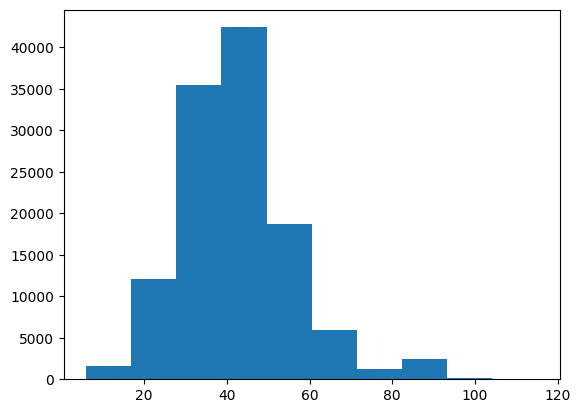

In [6]:
# plot the distribution of the title lengths
import matplotlib.pyplot as plt
plt.hist(title_lengths, bins=10)

In [7]:
train_titles[:2]

array(['AMD Debuts Dual-Core Opteron Processor',
       "Wood's Suspension Upheld (Reuters)"], dtype='<U115')

In [24]:
from reviews import wrangle_data
word_dimension = 9000 # about 95% fluency
sequence_length = 45

# oov == out of value token
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=word_dimension, oov_token='~~~')
tokenizer.fit_on_texts(train_titles)

train_data, train_labels, train_tokens = wrangle_data(tokenizer, train_titles, train_labels, sequence_length)
test_data, test_labels, test_tokens = wrangle_data(tokenizer, test_titles, test_labels, sequence_length)

In [25]:
train_labels.shape

(120000,)

In [26]:
import math

def fourth_root(n):
    return math.pow(n, 0.25)

In [27]:
from reviews import save_model, save_history
# Build the model

def compile_model(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

def cnn_model(word_dimension, embedding_dimension, sequence_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(word_dimension, embedding_dimension, input_length=sequence_length),
        tf.keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])

    return compile_model(model)

# CNN model
model_name = "ag-news-cnn"

earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'ckpts/reviews/{model_name}-'+'{epoch:02d}-{val_accuracy:.4f}')
embedding_dimension = int(fourth_root(word_dimension))

cnn = cnn_model(word_dimension, embedding_dimension, sequence_length)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 45, 9)             81000     
                                                                 
 conv1d_5 (Conv1D)           (None, 38, 128)           9344      
                                                                 
 global_average_pooling1d_5  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                      

In [28]:

history_cnn = cnn.fit(train_data, train_labels, validation_split=0.1, epochs=25, callbacks=[earlystop, checkpoint],
                        batch_size=64)

save_model(cnn, model_name, history_cnn, test_data, test_labels)
save_history(history_cnn, model_name)

Epoch 1/25
1671/1688 [============================>.] - ETA: 0s - loss: 0.7756 - accuracy: 0.6966INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-01-0.8480/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-01-0.8480/assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.7733 - accuracy: 0.6980 - val_loss: 0.4628 - val_accuracy: 0.8480
Epoch 2/25
1682/1688 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8476INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-02-0.8627/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-02-0.8627/assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.4762 - accuracy: 0.8476 - val_loss: 0.4144 - val_accuracy: 0.8627
Epoch 3/25
1679/1688 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8666INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-03-0.8633/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-03-0.8633/assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.4151 - accuracy: 0.8666 - val_loss: 0.4062 - val_accuracy: 0.8633
Epoch 4/25
1678/1688 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8729INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-04-0.8633/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-04-0.8633/assets


1688/1688 [==============================] - 6s 4ms/step - loss: 0.3850 - accuracy: 0.8728 - val_loss: 0.4065 - val_accuracy: 0.8633
Epoch 5/25
1670/1688 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8787INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-05-0.8633/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-05-0.8633/assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.3625 - accuracy: 0.8786 - val_loss: 0.4220 - val_accuracy: 0.8633
Epoch 6/25
1669/1688 [============================>.] - ETA: 0s - loss: 0.3419 - accuracy: 0.8855INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-06-0.8629/assets


INFO:tensorflow:Assets written to: ckpts/reviews/ag-news-cnn-06-0.8629/assets


238/238 [==============================] - 0s 770us/step - loss: 0.4116 - accuracy: 0.8613
INFO:tensorflow:Assets written to: models/reviews-ag-news-cnn-6-0.8613.tf/assets


INFO:tensorflow:Assets written to: models/reviews-ag-news-cnn-6-0.8613.tf/assets


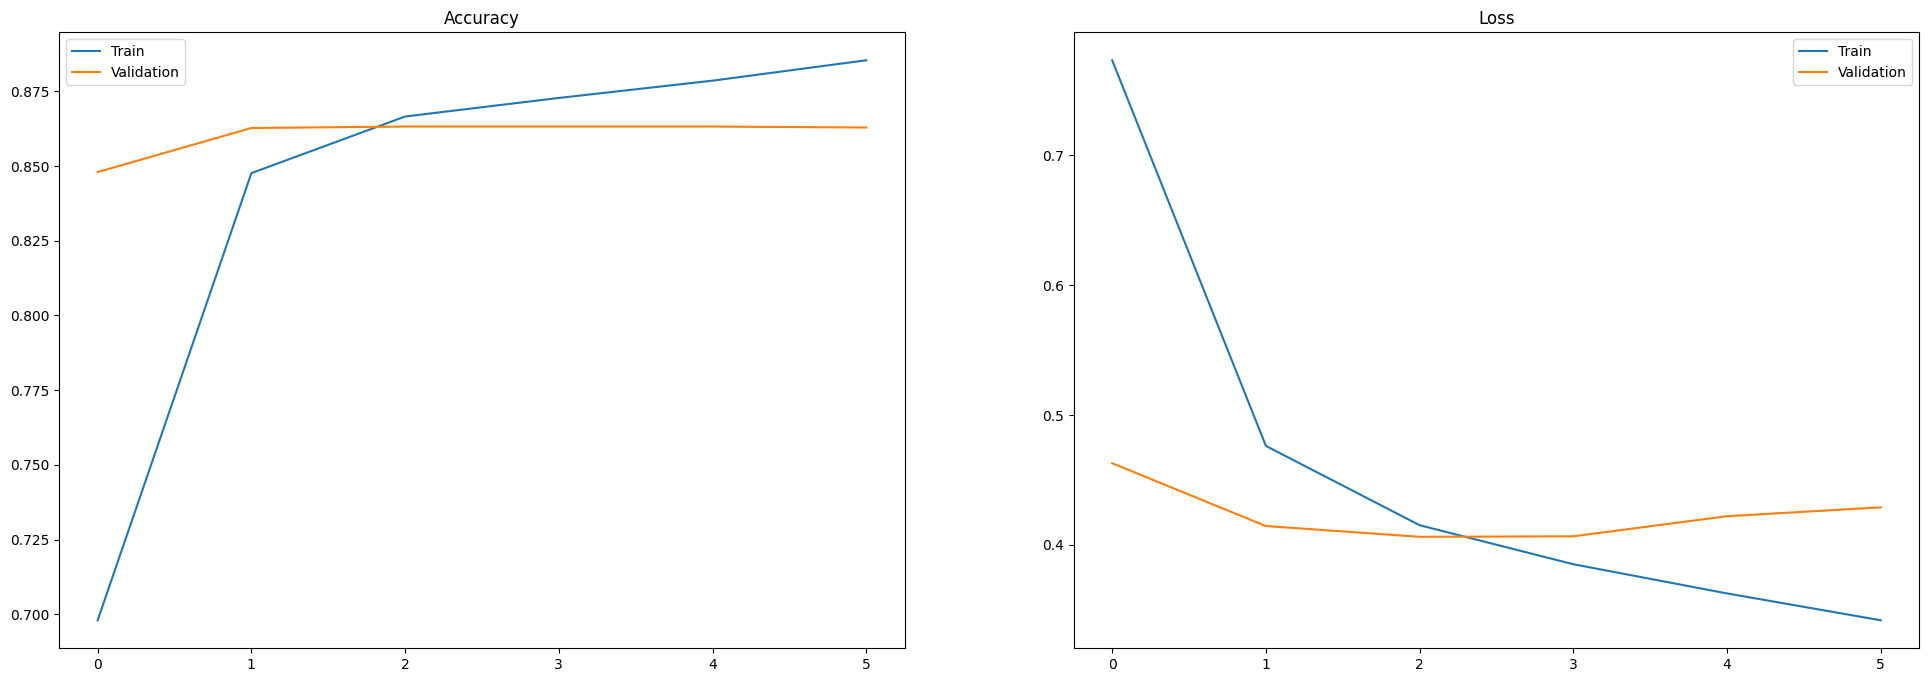

In [30]:
# plot the training history
from history import plot_history
plot_history(history_cnn)

In [31]:
# evaluate on test data
loss, accuracy = cnn.evaluate(test_data, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

238/238 [==============================] - 0s 729us/step - loss: 0.4116 - accuracy: 0.8613
Test Loss: 0.41159871220588684, Test Accuracy: 0.8613157868385315
